In [1]:
from cnn import CNNModel
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
import torch
import os
import sys

sys.path.append(os.path.abspath(os.path.dirname(os.path.dirname(os.path.abspath('')))))
from compute_results import plot_roc_curve, get_overall_metrics

In [2]:
RANDOM_SEED = 33
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Importing preprocessed data

In [3]:
project_root = '../..'
PATH_TRAIN_AXAM_CSV = f'{project_root}/data/train_AxAm_preprocessed.csv'
PATH_TRAIN_AMAM_CSV = f'{project_root}/data/train_AmAm_preprocessed.csv'
PATH_VAL_CSV = f'{project_root}/data/val_preprocessed.csv'
PATH_TEST_CSV = f'{project_root}/data/test_preprocessed.csv'

y_train_AxAm = pd.read_csv(PATH_TRAIN_AXAM_CSV, usecols=['label'])
y_train_AmAm = pd.read_csv(PATH_TRAIN_AMAM_CSV, usecols=['label'])
y_val = pd.read_csv(PATH_VAL_CSV, usecols=['label'])
y_test = pd.read_csv(PATH_TEST_CSV, usecols=['label'])

In [4]:
PATH_TRAIN_AXAM_NPY = f'{project_root}/data/train_AxAm_charlevel_features.npy'
PATH_TRAIN_AMAM_NPY = f'{project_root}/data/train_AmAm_charlevel_features.npy'
PATH_VAL_NPY = f'{project_root}/data/val_charlevel_features.npy'
PATH_TEST_NPY = f'{project_root}/data/test_charlevel_features.npy'

cl_features_train_AxAm = np.load(PATH_TRAIN_AXAM_NPY)
cl_features_train_AmAm = np.load(PATH_TRAIN_AMAM_NPY)
cl_features_val = np.load(PATH_VAL_NPY)
cl_features_test = np.load(PATH_TEST_NPY)

In [5]:
cl_features_train_AxAm = torch.tensor(cl_features_train_AxAm, dtype=torch.int32)
cl_features_train_AmAm = torch.tensor(cl_features_train_AmAm, dtype=torch.int32)
cl_features_val = torch.tensor(cl_features_val, dtype=torch.int32)
cl_features_test = torch.tensor(cl_features_test, dtype=torch.int32)

In [6]:
y_train_AxAm = torch.FloatTensor(y_train_AxAm.to_numpy().squeeze())
y_val = torch.FloatTensor(y_val.to_numpy().squeeze())

# CNN Baseline

In [7]:
MAX_FEATURES = cl_features_test.shape[1]
EMBEDDING_DIM = 128
DROPOUT_RATE = 0.3

LEARNING_RATE = 1e-5
WEIGHT_DECAY = 3e-5
NUM_EPOCHS = 18
BATCH_SIZE = 256
PATIENCE = 6
DELTA = 0.001

In [8]:
# # TRAINED ON GOOGLE COLAB USING GPU

# model_cnn_AxAm = CNNModel(max_features=256, embedding_dim=EMBEDDING_DIM, dropout_rate=DROPOUT_RATE)
# model_cnn_AxAm.compile(learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
# model_cnn_AxAm = model_cnn_AxAm.to(device)
# model_cnn_AxAm, train_avg_losses_AxAm, val_avg_losses_AxAm = model_cnn_AxAm.fit(
#                                                 X_train=cl_features_train_AxAm,
#                                                 y_train=y_train_AxAm,
#                                                 num_epochs= NUM_EPOCHS,
#                                                 batch_size=BATCH_SIZE,
#                                                 X_val=cl_features_val,
#                                                 y_val=y_val,
#                                                 patience=PATIENCE,
#                                                 delta=DELTA,
#                                             )

In [9]:
model_cnn_AxAm = CNNModel(max_features=256, embedding_dim=EMBEDDING_DIM, dropout_rate=DROPOUT_RATE)
model_cnn_AxAm.load_state_dict(torch.load(f'{project_root}/experiments/model_cnn_AxAm.pt'))
model_cnn_AxAm.eval()

CNNModel(
  (embedding_layer): Embedding(256, 128)
  (conv_layer): Conv1d(128, 1000, kernel_size=(2,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout_layer): Dropout(p=0.3, inplace=False)
  (dense_layer_1): Linear(in_features=257000, out_features=100, bias=True)
  (dense_layer_2): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [10]:
# TRAINED ON GOOGLE COLAB USING GPU

# model_lstm_AmAm = LSTMModel(max_features=MAX_FEATURES,
#                             embedding_dim=EMBEDDING_DIM,
#                             hidden_dim=HIDDEN_DIM,
#                             dropout_rate=DROPOUT_RATE)
# model_lstm_AmAm.compile(learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
# model_lstm_AmAm = model_lstm_AmAm.to(device)
# model_lstm_AmAm, train_avg_losses_AmAm, val_avg_losses_AmAm = model_lstm_AmAm.fit(
#                                                 X_train=cl_features_train_AmAm,
#                                                 y_train=y_train_AmAm,
#                                                 num_epochs= NUM_EPOCHS,
#                                                 batch_size=BATCH_SIZE,
#                                                 X_val=cl_features_val,
#                                                 y_val=y_val,
#                                                 patience=PATIENCE,
#                                                 delta=DELTA,
#                                             )

In [ ]:
model_lstm_AmAm = LSTMModel(max_features=MAX_FEATURES, embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM, dropout_rate=DROPOUT_RATE)
model_lstm_AmAm.load_state_dict(torch.load('../experiments/model_lstm_AmAm.pt'))
model_lstm_AmAm.eval()

##  Results

## AxAm trained

### Val

100%|██████████| 127/127 [14:48<00:00,  7.00s/it]


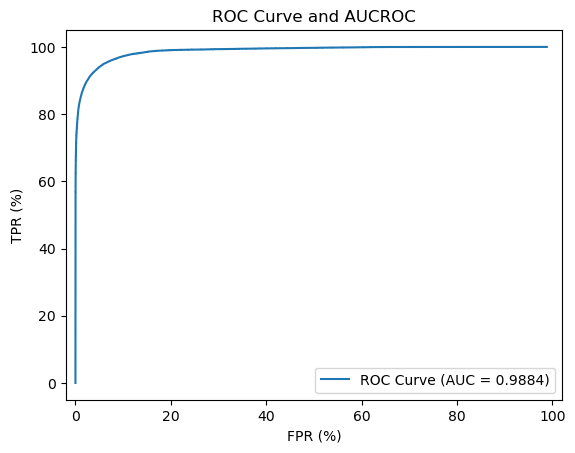

In [12]:
preds_val_AxAm = model_cnn_AxAm.batch_inference(cl_features_val, 1024)
plot_roc_curve(y_val, preds_val_AxAm)

In [13]:
fpr, tpr, thresholds = roc_curve(y_val, preds_val_AxAm)
df_val_roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds})
df_val_roc['youden-index'] = df_val_roc['tpr'] - df_val_roc['fpr']
BEST_VALIDATION_THRESHOLD_AXAM = df_val_roc.sort_values('youden-index', ascending=False).drop_duplicates('fpr').iloc[0]['thresholds']

In [14]:
get_overall_metrics(y_val, preds_val_AxAm > BEST_VALIDATION_THRESHOLD_AXAM)

{'acc': 0.9432615384615385,
 'tpr': 0.949,
 'fpr': 0.05846,
 'precision': 0.8296421494346661,
 'f1-score': 0.8853162510106349}

### Test

100%|██████████| 40/40 [01:16<00:00,  1.92s/it]


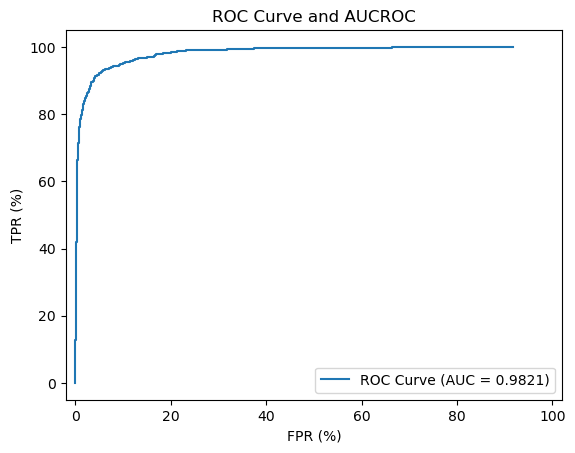

In [15]:
preds_test_AxAm = model_cnn_AxAm.batch_inference(cl_features_test, BATCH_SIZE)
plot_roc_curve(y_test, preds_test_AxAm)

In [16]:
get_overall_metrics(y_test, preds_test_AxAm > BEST_VALIDATION_THRESHOLD_AXAM)

{'acc': 0.8896,
 'tpr': 0.958,
 'fpr': 0.118,
 'precision': 0.47425742574257423,
 'f1-score': 0.6344370860927152}

In [17]:
# best_possible_test_threshold
fpr, tpr, thresholds = roc_curve(y_test, preds_test_AxAm)
df_val_roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds})
df_val_roc['youden-index'] = df_val_roc['tpr'] - df_val_roc['fpr']
best_possible_test_threshold_AxAm = df_val_roc.sort_values('youden-index', ascending=False).drop_duplicates('fpr').iloc[0]['thresholds']

In [18]:
get_overall_metrics(y_test, preds_test_AxAm > best_possible_test_threshold_AxAm)

{'acc': 0.9442,
 'tpr': 0.925,
 'fpr': 0.05366666666666667,
 'precision': 0.6569602272727273,
 'f1-score': 0.7682724252491695}

## AmAm trained

### Val

In [ ]:
preds_val_AmAm = model_lstm_AmAm.batch_inference(cl_features_val, BATCH_SIZE)
plot_roc_curve(y_val, preds_val_AmAm)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val, preds_val_AmAm)
df_val_roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds})
df_val_roc['youden-index'] = df_val_roc['tpr'] - df_val_roc['fpr']
BEST_VALIDATION_THRESHOLD_AMAM = df_val_roc.sort_values('youden-index', ascending=False).iloc[0]['thresholds']

In [ ]:
get_overall_metrics(y_val, preds_val_AmAm > BEST_VALIDATION_THRESHOLD_AMAM)

### Test

In [ ]:
preds_test_AmAm = model_lstm_AxAm.batch_inference(cl_features_test, BATCH_SIZE)
plot_roc_curve(y_test, preds_test_AmAm)

In [ ]:
get_overall_metrics(y_test, preds_test_AmAm > BEST_VALIDATION_THRESHOLD_AMAM)

In [ ]:
# best_possible_test_threshold
fpr, tpr, thresholds = roc_curve(y_test, preds_test_AmAm)
df_val_roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds})
df_val_roc['youden-index'] = df_val_roc['tpr'] - df_val_roc['fpr']
best_possible_test_threshold_AmAm = df_val_roc.sort_values('youden-index', ascending=False).iloc[0]['thresholds']

In [ ]:
get_overall_metrics(y_test, preds_test_AmAm > best_possible_test_threshold_AmAm)

In [ ]:
fpr, tpr, threshold = roc_curve(y_test, preds_test_AmAm, pos_label=1)
fnr = 1 - tpr
eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]

In [ ]:
get_overall_metrics(y_test, preds_test_AmAm > eer_threshold)